In [ ]:
%cd ..

In [106]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from etl.esios.provider import ESIOSDataProvider
import lab.functions as func

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import ExpandingWindowSplitter, temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_evaluation import evaluate
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_absolute_percentage_error

SEED=0
np.random.seed(SEED)

In [107]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [108]:
esios_provider = ESIOSDataProvider()
esios_tickers = esios_provider.get_tickers()
print(esios_tickers)

['DEMANDA_REAL', 'GENERACIÓN_MEDIDA_TOTAL', 'GENERACIÓN_MEDIDA_EÓLICA', 'GENERACIÓN_MEDIDA_HIDRÁULICA', 'GENERACIÓN_MEDIDA_NUCLEAR', 'GENERACIÓN_MEDIDA_SOLAR', 'GENERACIÓN_MEDIDA_CICLO_COMBINADO', 'GENERACIÓN_MEDIDA_CARBÓN', 'PRECIO_MERCADO_SPOT_DIARIO']


In [109]:
esios_df = esios_provider.get_all_series(freq="H", start_index="2022-04-01 00:00", end_index="2023-03-31 23:59")

contamination = 0.05
esios_df = func.remove_outliers_isolation_forests(esios_df, contamination)

esios_spot = esios_df["PRECIO_MERCADO_SPOT_DIARIO"]
esios_demand = esios_df["DEMANDA_REAL"]
X = esios_df.drop(['PRECIO_MERCADO_SPOT_DIARIO', 'GENERACIÓN_MEDIDA_TOTAL'], axis=1)

In [110]:
regressor_list = [DummyRegressor(), KNeighborsRegressor(), RandomForestRegressor(random_state=SEED),
                      GradientBoostingRegressor(random_state=SEED), SVR()]
regressor_str_list = ["DummyRegressor", "KNeighborsRegressor", "RandomForestRegressor", "GradientBoostingRegressor", "SVR"]

max_lags = [24*i for i in [7, 10, 14, 21, 30]]
cv_partitions = 6
forecasting_horizon = 168

In [153]:
cv_results_list_prepandemic[1]

,test_MeanAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,0.137017,0.025840,1.120359,1264,2018-05-23 15:00,DATE 2018-04-01 00:00 38.87 2018-04-01 01:0...,DATE 2018-05-23 16:00 64.22 2018-05-23 17:0...,2018-05-23 16:00 63.296 2018-05-23 17:00 ...
1,0.041740,0.062621,1.348920,2696,2018-07-22 07:00,DATE 2018-04-01 00:00 38.87 2018-04-01 01:0...,DATE 2018-07-22 08:00 57.50 2018-07-22 09:0...,2018-07-22 08:00 60.510 2018-07-22 09:00 ...
2,0.053593,0.104582,1.614189,4128,2018-09-19 23:00,DATE 2018-04-01 00:00 38.870000 2018-04-01 ...,DATE 2018-09-20 00:00 72.30 2018-09-20 01:0...,2018-09-20 00:00 70.8200 2018-09-20 01:00 ...
3,0.048967,0.158395,1.911060,5560,2018-11-18 15:00,DATE 2018-04-01 00:00 38.87 2018-04-01 01:0...,DATE 2018-11-18 16:00 60.01 2018-11-18 17:0...,2018-11-18 16:00 53.638 2018-11-18 17:00 ...
4,0.037261,0.206838,2.177892,6992,2019-01-17 07:00,DATE 2018-04-01 00:00 38.87 2018-04-01 01:0...,DATE 2019-01-17 08:00 68.13 2019-01-17 09:0...,2019-01-17 08:00 70.320 2019-01-17 09:00 ...
5,0.045911,0.253782,2.401086,8424,2019-03-17 23:00,DATE 2018-04-01 00:00 38.87 2018-04-01 01:0...,DATE 2019-03-18 00:00 39.01 2019-03-18 01:0...,2019-03-18 00:00 40.622 2019-03-18 01:00 ...


In [111]:
def crossval_window_size_make_reduction(y, X, regressor_list, regressor_str_list, max_lags, cv_partitions, forecasting_horizon):
    cv = ExpandingWindowSplitter(initial_window=math.floor(len(y)/cv_partitions)-forecasting_horizon, fh=list(range(1,forecasting_horizon+1)), step_length=math.floor(len(y)/cv_partitions))

    cv_results_list = []
    for max_lag in max_lags:
        for regressor, regressor_str in zip(regressor_list, regressor_str_list):
            print(f"Training setup: max_lag {max_lag} and regressor {regressor_str}")

            # refit strategy makes a new model on each iteration, not an update
            forecaster = make_reduction(regressor, strategy="recursive", window_length=max_lag, windows_identical=True)
            cv_results = evaluate(forecaster, y=y, X=X, cv=cv, strategy="refit", return_data=True, error_score="raise")
            cv_results_list.append(cv_results)

    return cv_results_list

In [112]:
cv_results_list = crossval_window_size_make_reduction(esios_spot[:-forecasting_horizon], X[:-forecasting_horizon], regressor_list, regressor_str_list, max_lags, cv_partitions, forecasting_horizon)

Training setup: max_lag 168 and regressor DummyRegressor
Training setup: max_lag 168 and regressor KNeighborsRegressor
Training setup: max_lag 168 and regressor RandomForestRegressor
Training setup: max_lag 168 and regressor GradientBoostingRegressor
Training setup: max_lag 168 and regressor SVR
Training setup: max_lag 240 and regressor DummyRegressor
Training setup: max_lag 240 and regressor KNeighborsRegressor
Training setup: max_lag 240 and regressor RandomForestRegressor
Training setup: max_lag 240 and regressor GradientBoostingRegressor
Training setup: max_lag 240 and regressor SVR
Training setup: max_lag 336 and regressor DummyRegressor
Training setup: max_lag 336 and regressor KNeighborsRegressor
Training setup: max_lag 336 and regressor RandomForestRegressor
Training setup: max_lag 336 and regressor GradientBoostingRegressor
Training setup: max_lag 336 and regressor SVR
Training setup: max_lag 504 and regressor DummyRegressor
Training setup: max_lag 504 and regressor KNeighbors

In [113]:
cv_results_df = pd.DataFrame(columns=['max_lag', 'model', 'mae', 'mape', 'fit_time'])
for i, result in enumerate(cv_results_list):
    regressor_i = int(i / len(regressor_list))
    lag_i = i % len(max_lags)

    mape = cv_results_list[0]["test_MeanAbsolutePercentageError"].mean()
    mae = 0
    for test, pred in zip(cv_results_list[i]["y_test"], cv_results_list[i]["y_pred"]):
        mae += mean_absolute_error(test, pred)
    row = {'max_lag': max_lags[lag_i],
           'model': regressor_str_list[regressor_i],
           'mae': mae,
           'mape': cv_results_list[i]["test_MeanAbsolutePercentageError"].mean(),
           'fit_time': cv_results_list[i]["fit_time"].sum()
    }
    row_df = pd.DataFrame([row])
    cv_results_df = pd.concat([cv_results_df, row_df], axis=0, ignore_index=True)

In [124]:
cv_results_df = cv_results_df.sort_values(by="mape")
cv_results_df

,max_lag,model,mae,mape,fit_time
8,504,KNeighborsRegressor,159.65261,0.426184,2134.554096
3,504,DummyRegressor,154.662282,0.434803,1183.179441
18,504,GradientBoostingRegressor,169.073804,0.445481,3018.005692
13,504,RandomForestRegressor,167.274794,0.457409,2067.720825
23,504,SVR,192.014669,0.494762,4165.979159
22,336,SVR,158.23492,0.507471,8292.495958
7,336,KNeighborsRegressor,167.848057,0.519429,3749.926439
12,336,RandomForestRegressor,176.565621,0.522728,4301.059681
17,336,GradientBoostingRegressor,168.079307,0.548083,6066.997807
2,336,DummyRegressor,166.405658,0.549699,3022.01


In [ ]:
func.crossval_plot_series(esios_spot, cv_results_list)

74.18468911173521
5.022255332092676


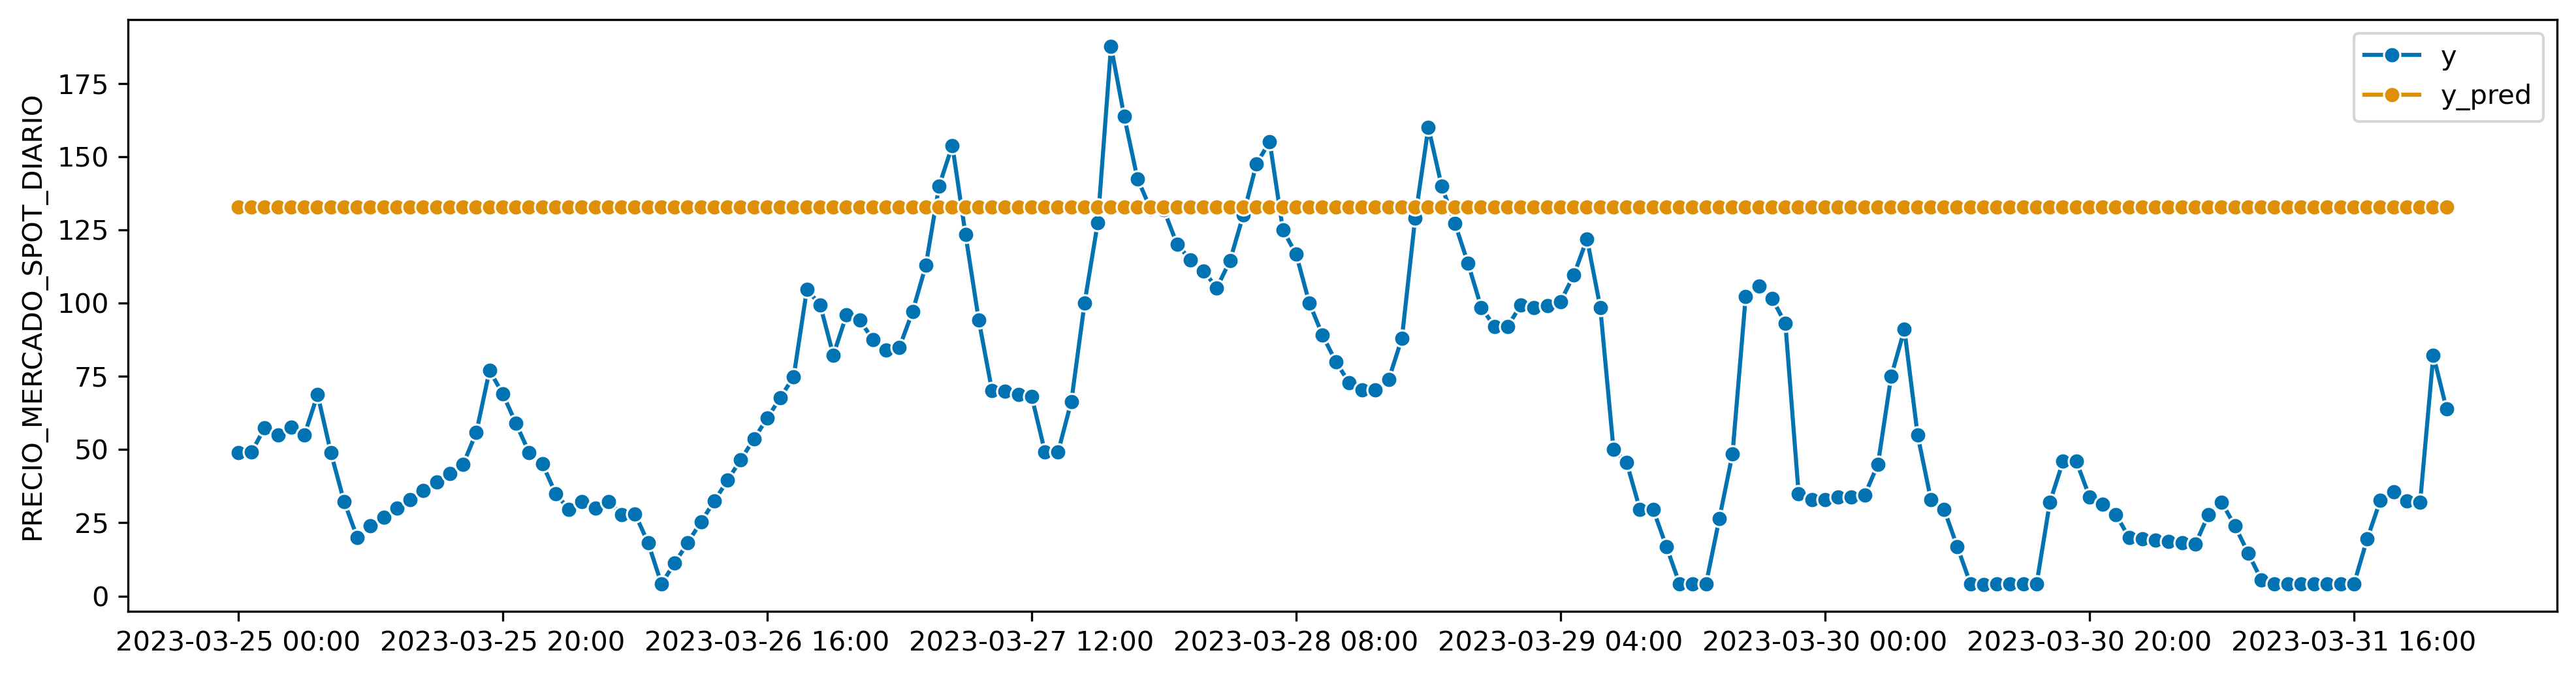

In [141]:
y_train, y_test, X_train, X_test = temporal_train_test_split(esios_spot, X, test_size=forecasting_horizon)

best_model_string = cv_results_df.iloc[1,1]
best_model = regressor_list[regressor_str_list.index(best_model_string)]

forecaster = make_reduction(best_model, strategy="recursive", window_length= cv_results_df.iloc[1,0], windows_identical=True)
forecaster.fit(y_train, X=X_train)

y_pred = forecaster.predict(X=X_test, fh=list(range(1,forecasting_horizon+1)))
#interval = forecaster.predict_interval(coverage=0.9, fh = list(range(1,forecasting_horizon+1)))
plot_series(y_test, y_pred, labels=["y", "y_pred"])
print(mean_absolute_error(y_test, y_pred))
print(mean_absolute_percentage_error(y_test, y_pred))

ValueError: obj should be a pd.DataFrame

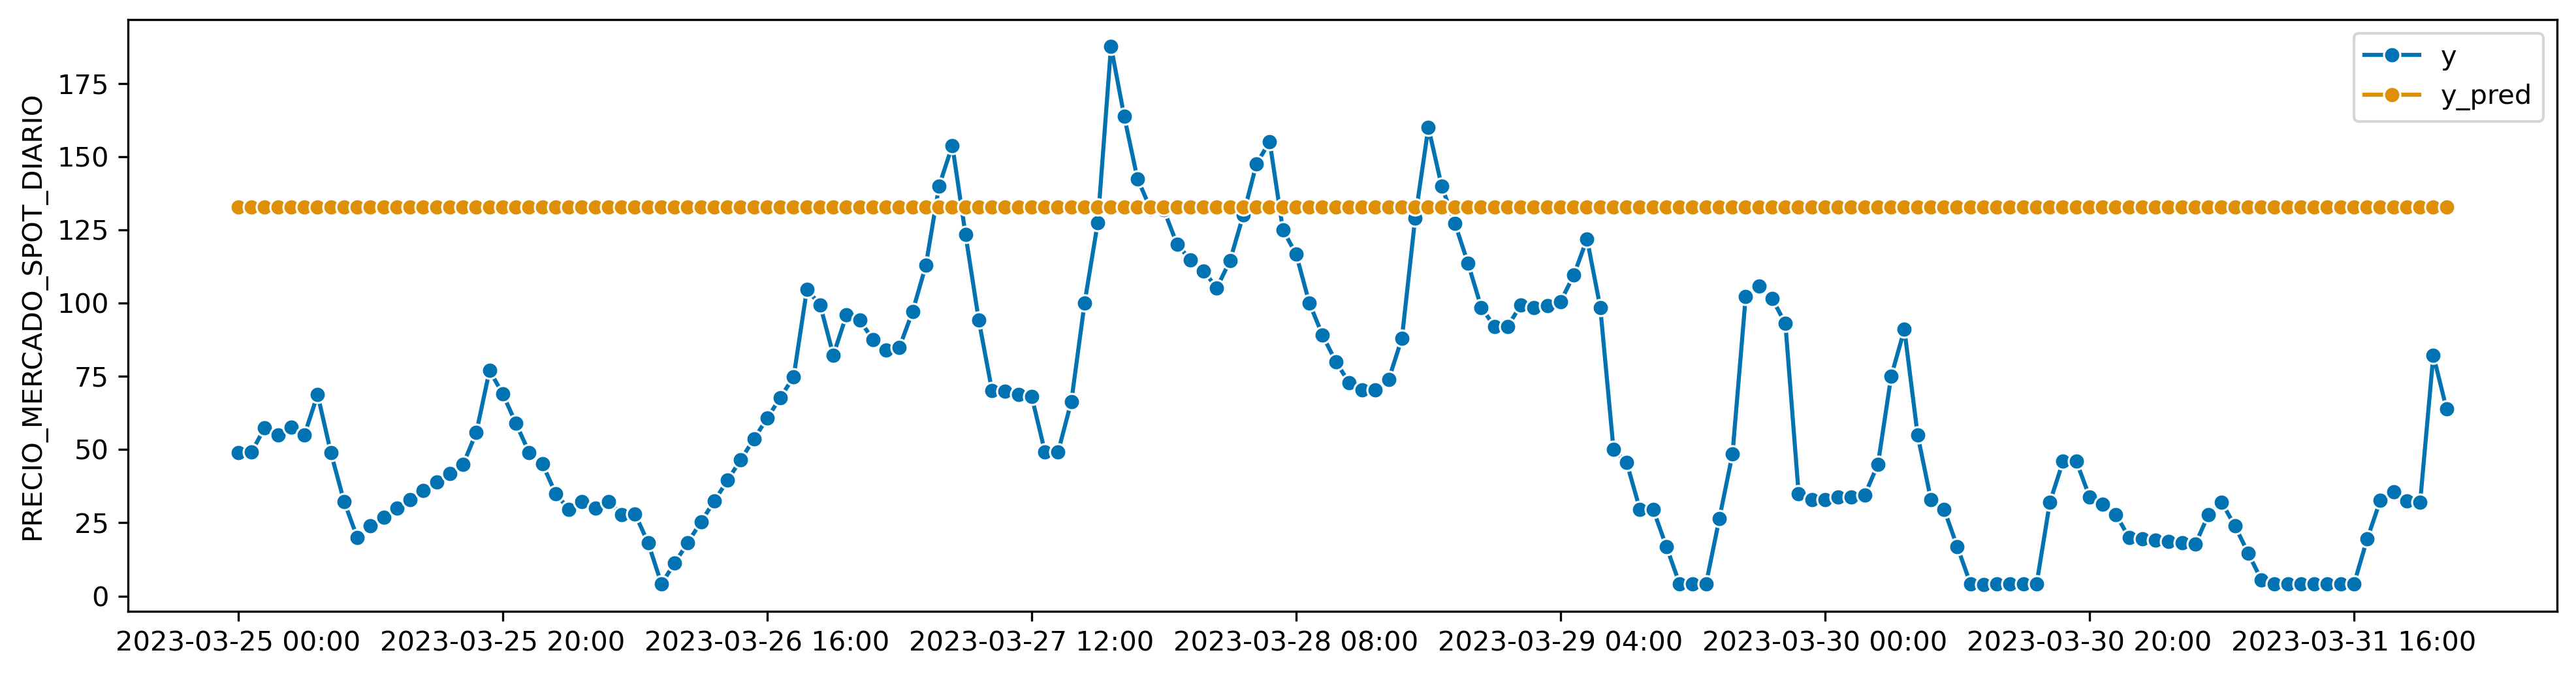

In [142]:
plot_series(y_test, y_pred, labels=["y", "y_pred"], pred_interval=True)

In [115]:
esios_df_prepandemic = esios_provider.get_all_series(freq="H", start_index="2018-04-01 00:00", end_index="2019-03-31 23:59")

contamination = 0.05
esios_df_prepandemic = func.remove_outliers_isolation_forests(esios_df_prepandemic, contamination)

esios_spot_prepandemic = esios_df_prepandemic["PRECIO_MERCADO_SPOT_DIARIO"]
esios_demand_prepandemic = esios_df_prepandemic["DEMANDA_REAL"]
X_prepandemic = esios_df_prepandemic.drop(['PRECIO_MERCADO_SPOT_DIARIO', 'GENERACIÓN_MEDIDA_TOTAL'], axis=1)

In [116]:
cv_results_list_prepandemic = crossval_window_size_make_reduction(esios_spot_prepandemic[:-forecasting_horizon], X_prepandemic[:-forecasting_horizon], regressor_list, regressor_str_list, max_lags, cv_partitions, forecasting_horizon)

Training setup: max_lag 168 and regressor DummyRegressor
Training setup: max_lag 168 and regressor KNeighborsRegressor
Training setup: max_lag 168 and regressor RandomForestRegressor
Training setup: max_lag 168 and regressor GradientBoostingRegressor
Training setup: max_lag 168 and regressor SVR
Training setup: max_lag 240 and regressor DummyRegressor
Training setup: max_lag 240 and regressor KNeighborsRegressor
Training setup: max_lag 240 and regressor RandomForestRegressor
Training setup: max_lag 240 and regressor GradientBoostingRegressor
Training setup: max_lag 240 and regressor SVR
Training setup: max_lag 336 and regressor DummyRegressor
Training setup: max_lag 336 and regressor KNeighborsRegressor
Training setup: max_lag 336 and regressor RandomForestRegressor
Training setup: max_lag 336 and regressor GradientBoostingRegressor
Training setup: max_lag 336 and regressor SVR
Training setup: max_lag 504 and regressor DummyRegressor
Training setup: max_lag 504 and regressor KNeighbors

In [117]:
len(cv_results_list_prepandemic)

25

In [135]:
cv_results_df_prepandemic = pd.DataFrame(columns=['max_lag', 'model', 'mae', 'mape', 'fit_time'])
for i, result in enumerate(cv_results_list_prepandemic):
    regressor_i = int(i / len(regressor_list))
    lag_i = i % len(max_lags)

    mape = cv_results_list_prepandemic[0]["test_MeanAbsolutePercentageError"].mean()
    mae = 0
    for test, pred in zip(cv_results_list_prepandemic[i]["y_test"], cv_results_list_prepandemic[i]["y_pred"]):
        mae += mean_absolute_error(test, pred)
    row = {'max_lag': max_lags[lag_i],
           'model': regressor_str_list[regressor_i],
           'mae': mae,
           'mape': cv_results_list_prepandemic[i]["test_MeanAbsolutePercentageError"].mean(),
           'fit_time': cv_results_list_prepandemic[i]["fit_time"].sum()
    }
    row_df = pd.DataFrame([row])
    cv_results_df_prepandemic = pd.concat([cv_results_df_prepandemic, row_df], axis=0, ignore_index=True)

In [137]:
cv_results_df_prepandemic = cv_results_df_prepandemic.sort_values(by="mae")
cv_results_df_prepandemic

,max_lag,model,mae,mape,fit_time
8,504,KNeighborsRegressor,16.666276,0.046659,1478.141924
3,504,DummyRegressor,16.939786,0.047808,1045.95659
12,336,RandomForestRegressor,19.353637,0.053382,3972.83826
2,336,DummyRegressor,20.263457,0.057544,2066.43394
7,336,KNeighborsRegressor,21.043088,0.058893,2902.48557
13,504,RandomForestRegressor,21.675311,0.059186,2044.204501
22,336,SVR,21.966461,0.060203,8340.370907
1,240,DummyRegressor,22.206706,0.060748,0.81206
17,336,GradientBoostingRegressor,22.360674,0.060703,5760.346861
18,504,GradientBoostingRegressor,23.714946,0.064331,2984.038604


In [ ]:
func.crossval_plot_series(esios_spot_prepandemic, cv_results_list_prepandemic)

11.511450649992934
0.2541732942977943


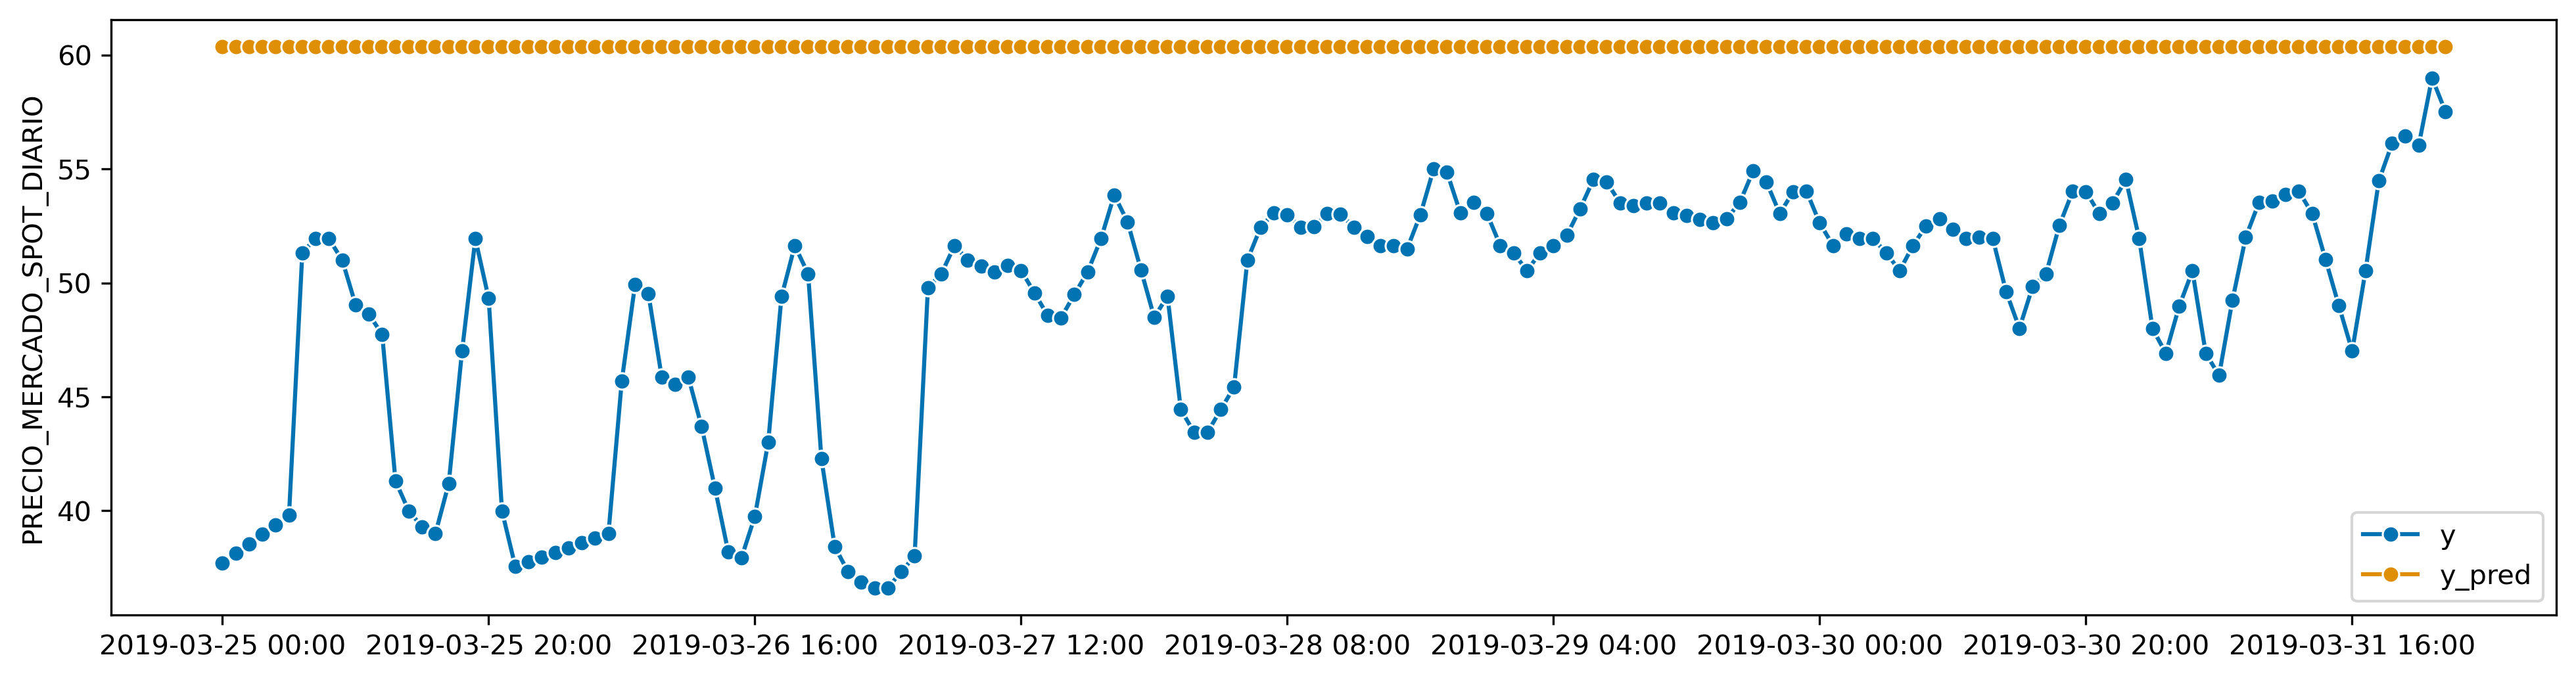

In [139]:
y_train, y_test, X_train, X_test = temporal_train_test_split(esios_spot_prepandemic, X_prepandemic, test_size=forecasting_horizon)

best_model_string = cv_results_df_prepandemic.iloc[1,1]
best_model = regressor_list[regressor_str_list.index(best_model_string)]

forecaster = make_reduction(best_model, strategy="recursive", window_length= cv_results_df.iloc[0,0], windows_identical=True)
forecaster.fit(y_train, X=X_train)

y_pred = forecaster.predict(X=X_test, fh=list(range(1,forecasting_horizon+1)))
#interval = forecaster.predict_interval(coverage=0.9, fh = list(range(1,forecasting_horizon+1)))
plot_series(y_test, y_pred, labels=["y", "y_pred"])
print(mean_absolute_error(y_test, y_pred))
print(mean_absolute_percentage_error(y_test, y_pred))